# Price Model Data Exploration

This notebook is the V1 model of allowed amounts

#### Model Formula

![Price_Model_V1](mod_v1_formula.png)

Model uses medicare fees by procedure and facility category, along with patient state, payer id, payer channel, procedure modifiers and setting of care variables.

Model is applied to professional claims only, and data is trimmed so that the bottom and top 1% of prices are excluded.

## Notebook Setup and Local Functions

### Install packages

In [1]:
#install h20 for modeling exploration, need to set this up on hub
!pip install h2o

  Using cached h2o-3.32.1.3-py2.py3-none-any.whl


### Import libraries

In [2]:
#basic math/stats/graphs libraries
import numpy as np
from numpy import sqrt, exp, log, mean
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from math import ceil, floor
from ipywidgets import Layout, Button, Box, FloatText, Textarea,Dropdown, Label, IntSlider, Checkbox, interact, interactive
sns.set_style("whitegrid")

In [3]:
#basic model/pandas libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime
import h2o
from h2o.automl import H2OAutoML

In [4]:
#install snowflake connector
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


### Define functions

In [5]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"',
               select_statement=None, limit=None, where=None, 
               diag=False, sample_n=None):
    
    if select_statement is not None:
        sql=select_statement 
    
    else:
        sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'average','median','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

In [6]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    return current_time

### Define Databases

In [7]:
#encounters database
enc_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ENCOUNTERSMX_LS_GA"'

#allowed amounts database
aa_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ALLOWEDAMOUNTS_GA"'

#enhanced allowed amounts database (Jan, Feb 2020)
aa_enh_db='"SANDBOX_KRAO"."COSTOFCARE"."ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.01% sample)
aa_enh_db_001pct='"SANDBOX_KRAO"."COSTOFCARE"."RANDOM_001PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.1% sample)
aa_enh_db_01pct='"SANDBOX_KRAO"."COSTOFCARE"."RANDOM_01PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (1M random sample)
aa_enh_db_1M='"SANDBOX_KRAO"."COSTOFCARE"."RANDOM_1M_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#sum costs per patient and soc
aa_sum_cost_pp_soc='"SANDBOX_KRAO"."COSTOFCARE"."SUM_COST_PER_PATIENT_SOC"'

#sum costs per patient and soc (1 M sample)
aa_sum_cost_pp_soc_1M='"SANDBOX_KRAO"."COSTOFCARE"."SUM_COST_PER_PATIENT_SOC_1M_SAMPLE"'

#enhanced allowed amounts database (.1% sample)
aa_mod_01pct_db='"SANDBOX_KRAO"."COSTOFCARE"."RANDOM_01PCT_MODEL_V1_DATA"'

#enhanced allowed amounts database (1M random sample)
aa_mod_1M_db='"SANDBOX_KRAO"."COSTOFCARE"."RANDOM_1M_MODEL_V1_DATA"'

#summary stats for allowed amounts from analysis sample
aa_pp_summary_db='"SANDBOX_KRAO"."COSTOFCARE"."PROCEDURE_PRICE_AA_SUMMARY"'


In [8]:
#create pandas data frames for 1% samples (professional claims only)
aa_mod_01pct_df=pull_snfdb(db=aa_mod_01pct_db)
aa_mod_01pct_df=aa_mod_01pct_df[aa_mod_01pct_df["ALLOWED_AMOUNT"].notna()]
aa_mod_01pct_df=aa_mod_01pct_df[aa_mod_01pct_df["CLAIM_TYPE_CODE"]=='P']

##create pandas data frames for 1M samples (professional claims only)
#aa_mod_1M_df=pull_snfdb(db=aa_mod_1M_db)
#aa_mod_1M_df=aa_mod_1M_df[aa_mod_1M_df["ALLOWED_AMOUNT"].notna()]
#aa_mod_1M_df=aa_mod_1M_df[aa_mod_1M_df["CLAIM_TYPE_CODE"]=='P']

#create pandas data frames for allowed amounts procedure price summary 
aa_pp_summary_df=pull_snfdb(db=aa_pp_summary_db)
aa_pp_summary_df=aa_pp_summary_df[aa_pp_summary_df["CLAIM_TYPE"]=='P']

#calculate global data summary
aa_enh_db_summ_df=pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=aa_enh_db)

In [9]:
aa_mod_01pct_df.head().T

,0,4,5,6,7
PROCEDURE,"""64647""","""94250""","""94010""","""94010""","""94010"""
PATIENT_STATE,IL,FL,FL,MA,MA
PAYER_KH_ID,17,195,195,123,123
PAYER_CHANNEL,Managed Medicaid,Medicare,Medicare,Managed Medicaid,Managed Medicaid
CLAIM_TYPE_CODE,P,P,P,P,P
MODIFIER_1,None,None,None,"""26""",None
MODIFIER_2,None,None,None,None,None
UNITS,None,1,1,1,None
PLACE_OF_SERVICE,"""22""","""11""","""11""","""11""","""11"""
VISIT_SETTING_OF_CARE,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit


In [10]:
aa_pp_summary_df.head().T

,0,3,5,6,7
PROCEDURE,"""26445""","""7900""","""03723ZZ""","""4135F""","""ULTRA"""
PROCEDURE_DESCRIPTION,Removal of scar tissue to release tendon of pa...,Closed reduction of fracture without internal ...,"Dilation of Innominate Artery, Percutaneous Ap...",Systemic corticosteroids prescribed (ome),None
CLAIM_TYPE,P,P,P,P,P
COUNT_EKEY,953,1,1,159,2
COUNT_AA,381,0,0,9,0
PERCENTILE_1,125,NaN,NaN,0.01,NaN
PERCENTILE_5,252.555,NaN,NaN,0.01,NaN
PERCENTILE_10,273.91,NaN,NaN,0.01,NaN
STDDEV_AA,1009.98,NaN,NaN,124.765,NaN
MIN_AA,120,NaN,NaN,0.01,NaN


In [11]:
aa_enh_db_summ_df.T

,0
ALLOWED_AMOUNT_count,1.322709e+09
ALLOWED_AMOUNT_stddev,6.206801e+03
ALLOWED_AMOUNT_min,1.000000e-02
ALLOWED_AMOUNT_1percentile,1.189305e+00
ALLOWED_AMOUNT_5percentile,3.849599e+00
ALLOWED_AMOUNT_10percentile,6.989455e+00
ALLOWED_AMOUNT_25percentile,1.736109e+01
ALLOWED_AMOUNT_average,1.671282e+02
ALLOWED_AMOUNT_median,5.556000e+01
ALLOWED_AMOUNT_75percentile,1.141772e+02


### Generate Regression data frames

In [12]:
#column name vectors

keep_cols=['PROCEDURE','PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT','MPFS_AVG_FEE']

xNames=['LOG_MPFS_AVG_FEE','PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE']

yName='LOG_ALLOWED_AMOUNT'

#### Split into "prior/model data": prior is to calculate global and procedure mean

In [13]:
aa_enh_db_summ_df.T

,0
ALLOWED_AMOUNT_count,1.322709e+09
ALLOWED_AMOUNT_stddev,6.206801e+03
ALLOWED_AMOUNT_min,1.000000e-02
ALLOWED_AMOUNT_1percentile,1.189305e+00
ALLOWED_AMOUNT_5percentile,3.849599e+00
ALLOWED_AMOUNT_10percentile,6.989455e+00
ALLOWED_AMOUNT_25percentile,1.736109e+01
ALLOWED_AMOUNT_average,1.671282e+02
ALLOWED_AMOUNT_median,5.556000e+01
ALLOWED_AMOUNT_75percentile,1.141772e+02


In [14]:
aa_pp_summary_df.shape

(29682, 16)

In [15]:
len(aa_pp_summary_df["PROCEDURE"].unique())

29657

In [16]:
#modeling frames
X_model=aa_mod_01pct_df[keep_cols]

In [17]:
# incorporate MPFS Fees

X_model["LOG_MPFS_AVG_FEE"]=log(X_model["MPFS_AVG_FEE"])
X_model["LOG_ALLOWED_AMOUNT"]=log(X_model["ALLOWED_AMOUNT"])


#hacky cross merge to incorporate avg/median proc prices
X_model['TEMP_COL'] = 1
aa_enh_db_summ_df['TEMP_COL'] = 1
X_model=X_model.merge(aa_enh_db_summ_df[["ALLOWED_AMOUNT_average",
        "ALLOWED_AMOUNT_median","TEMP_COL"]], on='TEMP_COL', how='inner')
print(X_model.shape)

#pull in avg/median prices by procedure

X_model=X_model.merge(aa_pp_summary_df[["AVERAGE_AA", "MEDIAN_AA", "PROCEDURE"]], on="PROCEDURE",how="left")
print(X_model.shape)

#clean up data frame

X_model=X_model[~X_model["LOG_ALLOWED_AMOUNT"].isna()]
X_model=X_model[~X_model["LOG_MPFS_AVG_FEE"].isna()]

X_model.rename(columns={"AVERAGE_AA": "PROC_AVERAGE_AA", "MEDIAN_AA": "PROC_MEDIAN_AA",
                        "ALLOWED_AMOUNT_average":"ALL_AVERAGE_AA", "ALLOWED_AMOUNT_median":"ALL_MEDIAN_AA"},
               inplace=True)

X_model.drop('TEMP_COL', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(148200, 16)
(148200, 18)


In [18]:
X_model.head().T

,0,1,2,3,4
PROCEDURE,"""64647""","""94250""","""94010""","""94010""","""94010"""
PATIENT_STATE,IL,FL,FL,MA,MA
PAYER_KH_ID,17,195,195,123,123
PAYER_CHANNEL,Managed Medicaid,Medicare,Medicare,Managed Medicaid,Managed Medicaid
MODIFIER_1,None,None,None,"""26""",None
MODIFIER_2,None,None,None,None,None
UNITS,None,1,1,1,None
PLACE_OF_SERVICE,"""22""","""11""","""11""","""11""","""11"""
VISIT_SETTING_OF_CARE,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit
ALLOWED_AMOUNT,169.67,28.53,38,22.96,22.96


In [19]:
X_model.shape

(148200, 17)

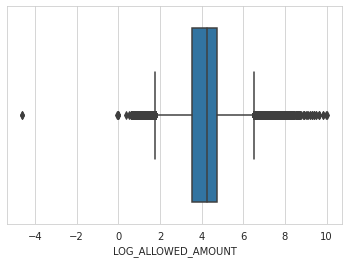

In [20]:
sns.boxplot(x=X_model["LOG_ALLOWED_AMOUNT"])

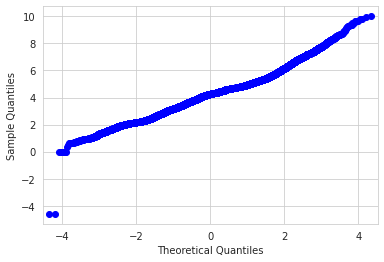

In [21]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

a = np.random.normal(5, 5, 250)
sm.qqplot(X_model["LOG_ALLOWED_AMOUNT"])
plt.show()

Note: Not normally distributed? Trim tail?

### Run Basic Model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    X_model[yName],
                                                    test_size=0.65, random_state=0)

In [23]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy6wq1_sk
  JVM stdout: /tmp/tmpy6wq1_sk/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmpy6wq1_sk/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_jovyan_7vd4vk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"accepting new members, healthy"


In [24]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=300, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train[xNames] ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test[xNames]], axis=1))
aml.train(x=xNames, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
18:27:21.508: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [25]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210702_182721,0.130028,0.360593,0.130028,0.240829,nan
StackedEnsemble_BestOfFamily_AutoML_20210702_182721,0.134466,0.366696,0.134466,0.244723,nan
XGBoost_grid__1_AutoML_20210702_182721_model_1,0.138406,0.37203,0.138406,0.247547,nan
XGBoost_grid__1_AutoML_20210702_182721_model_2,0.138625,0.372324,0.138625,0.251644,nan
XGBoost_2_AutoML_20210702_182721,0.138809,0.372571,0.138809,0.249782,nan
XGBoost_1_AutoML_20210702_182721,0.14378,0.379183,0.14378,0.258008,nan
GBM_4_AutoML_20210702_182721,0.144815,0.380545,0.144815,0.256452,nan
GBM_3_AutoML_20210702_182721,0.146174,0.382327,0.146174,0.258448,nan
GBM_2_AutoML_20210702_182721,0.149252,0.386332,0.149252,0.26217,nan
GBM_5_AutoML_20210702_182721,0.154354,0.392879,0.154354,0.263745,nan


In [26]:
model_ids=aml.leaderboard.as_data_frame()["model_id"].tolist()

In [27]:
model_ids

['StackedEnsemble_AllModels_AutoML_20210702_182721',
 'StackedEnsemble_BestOfFamily_AutoML_20210702_182721',
 'XGBoost_grid__1_AutoML_20210702_182721_model_1',
 'XGBoost_grid__1_AutoML_20210702_182721_model_2',
 'XGBoost_2_AutoML_20210702_182721',
 'XGBoost_1_AutoML_20210702_182721',
 'GBM_4_AutoML_20210702_182721',
 'GBM_3_AutoML_20210702_182721',
 'GBM_2_AutoML_20210702_182721',
 'GBM_5_AutoML_20210702_182721',
 'GBM_1_AutoML_20210702_182721',
 'XGBoost_3_AutoML_20210702_182721',
 'DRF_1_AutoML_20210702_182721',
 'GBM_grid__1_AutoML_20210702_182721_model_2',
 'GBM_grid__1_AutoML_20210702_182721_model_1',
 'XRT_1_AutoML_20210702_182721',
 'DeepLearning_1_AutoML_20210702_182721',
 'DeepLearning_grid__1_AutoML_20210702_182721_model_1',
 'GLM_1_AutoML_20210702_182721',
 'DeepLearning_grid__2_AutoML_20210702_182721_model_1',
 'DeepLearning_grid__3_AutoML_20210702_182721_model_1']

StackedEnsemble_AllModels_AutoML_20210702_182721
plot attempt failed
StackedEnsemble_BestOfFamily_AutoML_20210702_182721
plot attempt failed
XGBoost_grid__1_AutoML_20210702_182721_model_1


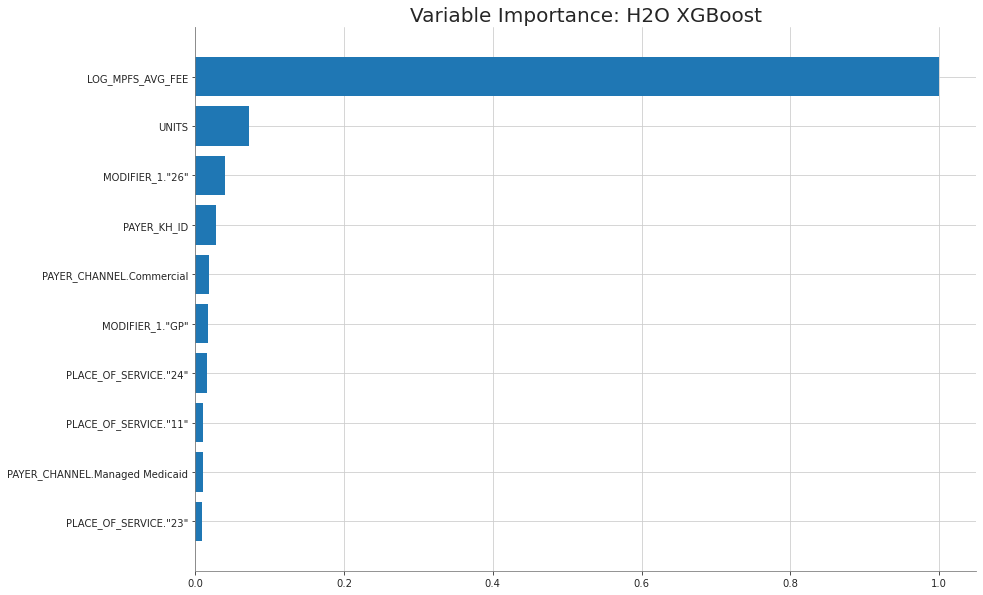

XGBoost_grid__1_AutoML_20210702_182721_model_2


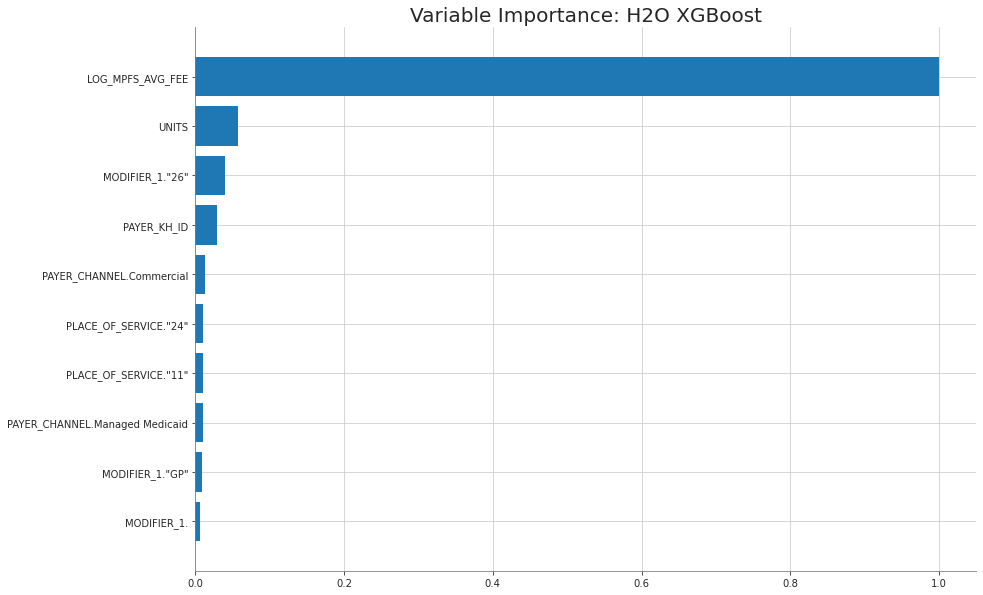

XGBoost_2_AutoML_20210702_182721


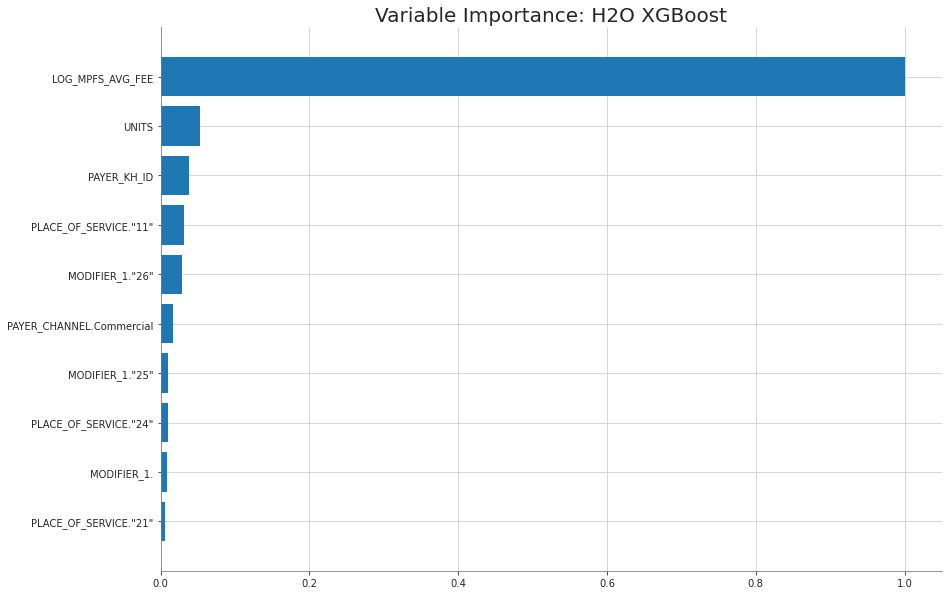

In [28]:
for model in model_ids[:5]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.varimp_plot()
    except:
        print ("plot attempt failed")

StackedEnsemble_AllModels_AutoML_20210702_182721
StackedEnsemble_BestOfFamily_AutoML_20210702_182721
XGBoost_grid__1_AutoML_20210702_182721_model_1
XGBoost_grid__1_AutoML_20210702_182721_model_2
XGBoost_2_AutoML_20210702_182721


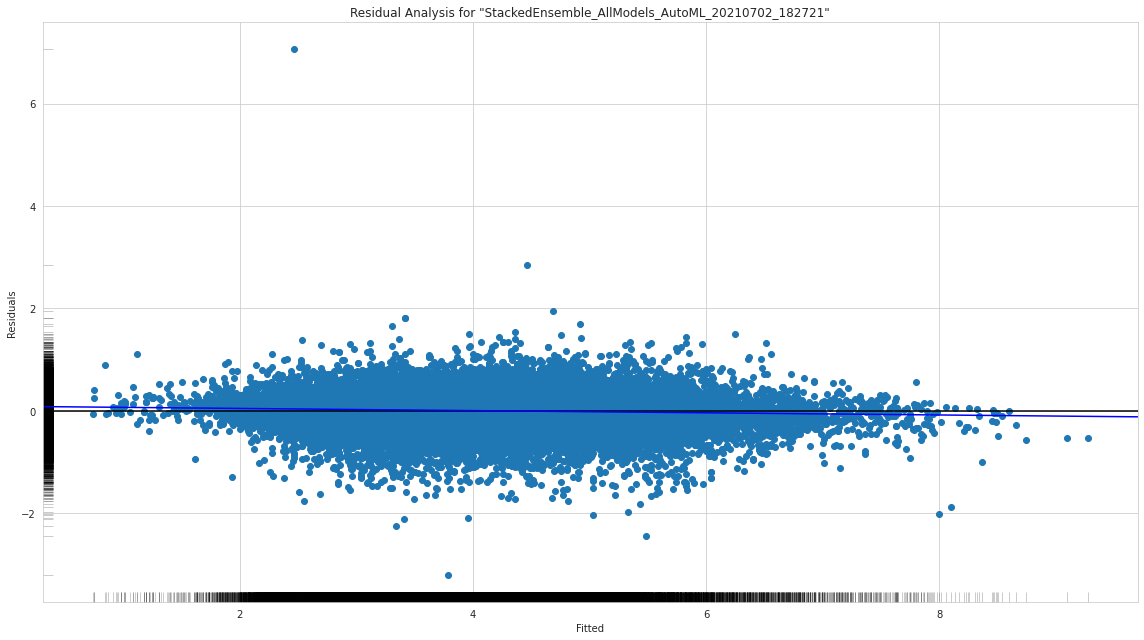

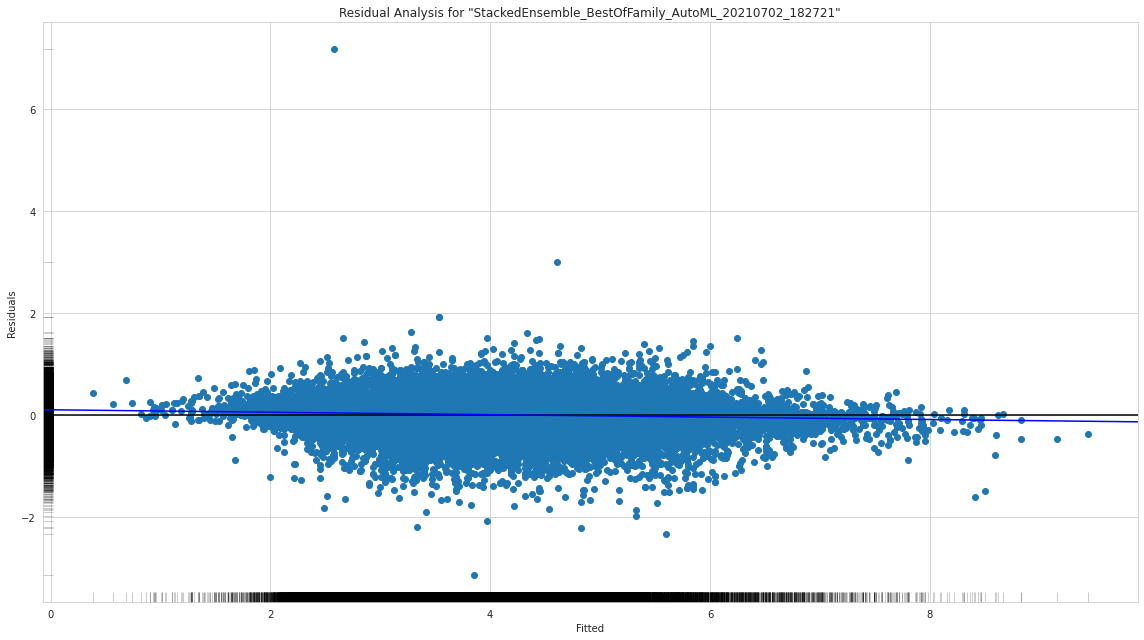

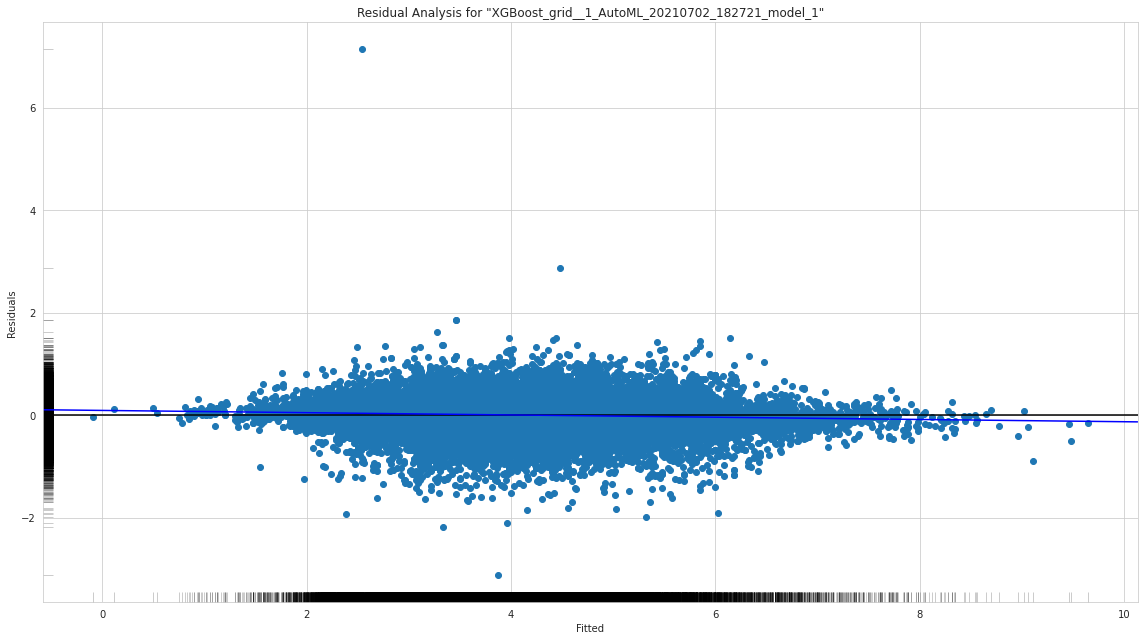

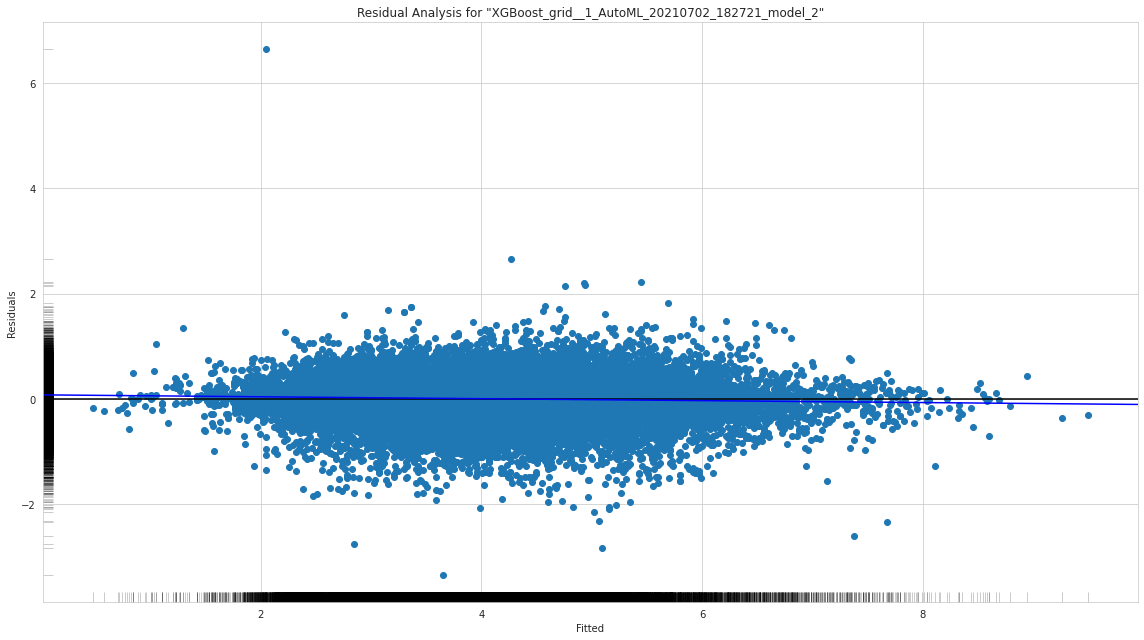

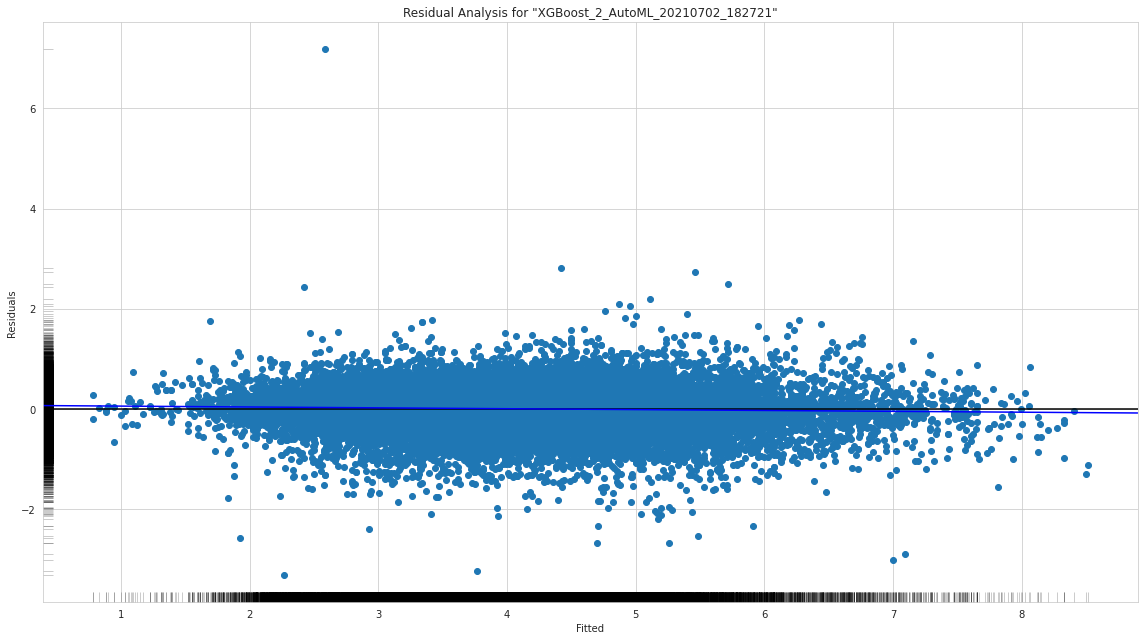

In [29]:
for model in model_ids[:5]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.residual_analysis_plot(trainH2o)
    except:
        print ("plot attempt failed")

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

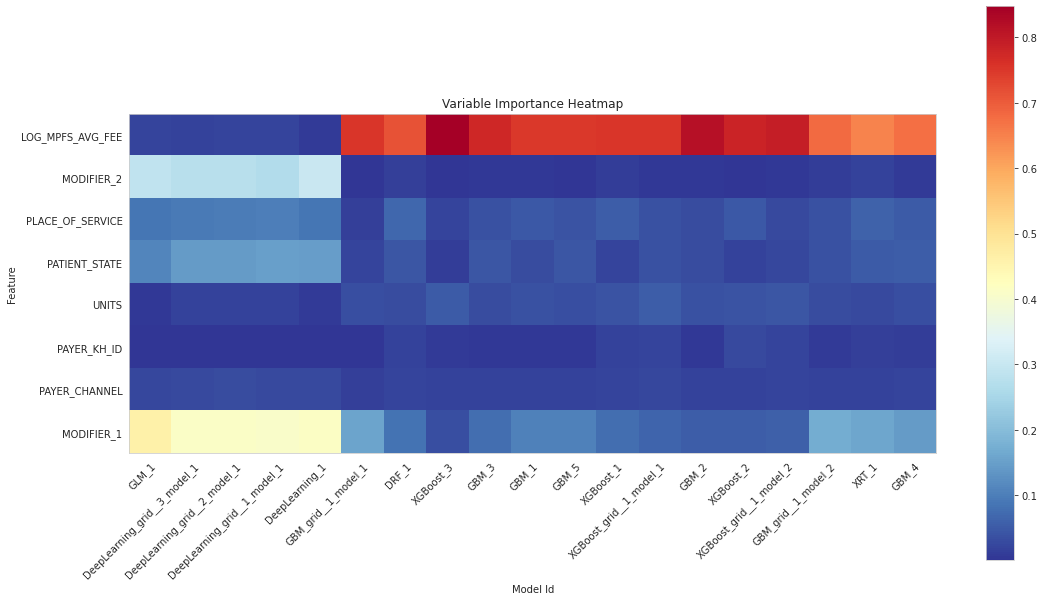

In [30]:
exa=aml.explain(trainH2o, include_explanations=["varimp_heatmap"])

In [32]:
mse2=sqrt(mse(X_train["LOG_MPFS_AVG_FEE"],X_train["LOG_ALLOWED_AMOUNT"]))
mse3=sqrt(mse(log(X_train["PROC_AVERAGE_AA"]),X_train["LOG_ALLOWED_AMOUNT"]))
mse4=sqrt(mse(log(X_train["ALL_AVERAGE_AA"]),X_train["LOG_ALLOWED_AMOUNT"]))
print(mse2, mse3, mse4)

0.5595493036854498 0.5180006280868625 1.3700098769018347


In [ ]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    yhat=temp.predict(testH2o).as_data_frame()
    temp_result=pd.concat([yhat["predict"].reset_index(), X_test.reset_index()], axis=1, ignore_index=True)
    temp_result.columns=["index1", "yhat", "index2"]+X_test.columns.to_list()
    temp_result["residual"]=yhat-temp_result["LOG_ALLOWED_AMOUNT"]
    mse1=sqrt(mse(yhat,temp_result["LOG_ALLOWED_AMOUNT"]))
    mse2=sqrt(mse(temp_result["LOG_MPFS_AVG_FEE"],temp_result["LOG_ALLOWED_AMOUNT"]))
    mse3=sqrt(mse(log(temp_result["PROC_AVERAGE_AA"]),temp_result["LOG_ALLOWED_AMOUNT"]))
    mse4=sqrt(mse(log(temp_result["ALL_AVERAGE_AA"]),temp_result["LOG_ALLOWED_AMOUNT"]))
    print(mse1,mse2, mse3, mse4)


StackedEnsemble_AllModels_AutoML_20210702_162537
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""63"", ""74"", ""81"", ""96"", ""CR"", ""ET"", ""F4"", ""G0"", ""GB"", ""GD"", ...12 not listed..., ""Q7"", ""QW"", ""SU"", ""SZ"", ""T2"", ""T3"", ""TF"", ""TV"", ""UH"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""55"", ""56"", ""62"", ""CG"", ""CT"", ""E1"", ""E4"", ""EP"", ""F1"", ""F5"", ...9 not listed..., ""MF"", ""RC"", ""ST"", ""T1"", ""T5"", ""T6"", ""T9"", ""U4"", ""UH"", ""X1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""07"", ""25"", ""26""]
  warnings.warn(w)


In [ ]:
sns.distplot(log(temp_result["residual"]),
         kde_kws={"shade": True}, hist=False)

In [35]:
aml2 = H2OAutoML(max_runtime_secs=300, seed=1,include_algos = ["GLM", "DRF"])
#trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train[xNames] ], axis=1))
#testH2o=h2o.H2OFrame(pd.concat([y_test,X_test[xNames]], axis=1))
aml2.train(x=xNames, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

AutoML progress: |
18:37:57.200: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [36]:
aml2.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_1_AutoML_20210702_183757,0.154644,0.393249,0.154644,0.265519,nan
XRT_1_AutoML_20210702_183757,0.171666,0.414326,0.171666,0.287309,nan
GLM_1_AutoML_20210702_183757,0.216763,0.465578,0.216763,0.331053,nan


In [37]:
model_ids=aml2.leaderboard.as_data_frame()["model_id"].tolist()

In [38]:
model_ids

['DRF_1_AutoML_20210702_183757',
 'XRT_1_AutoML_20210702_183757',
 'GLM_1_AutoML_20210702_183757']

DRF_1_AutoML_20210702_183757


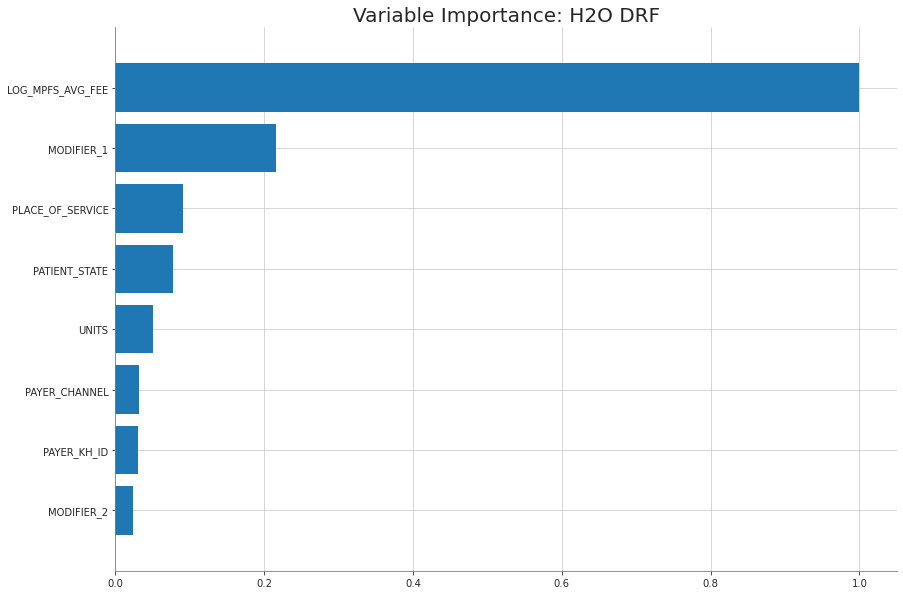

XRT_1_AutoML_20210702_183757


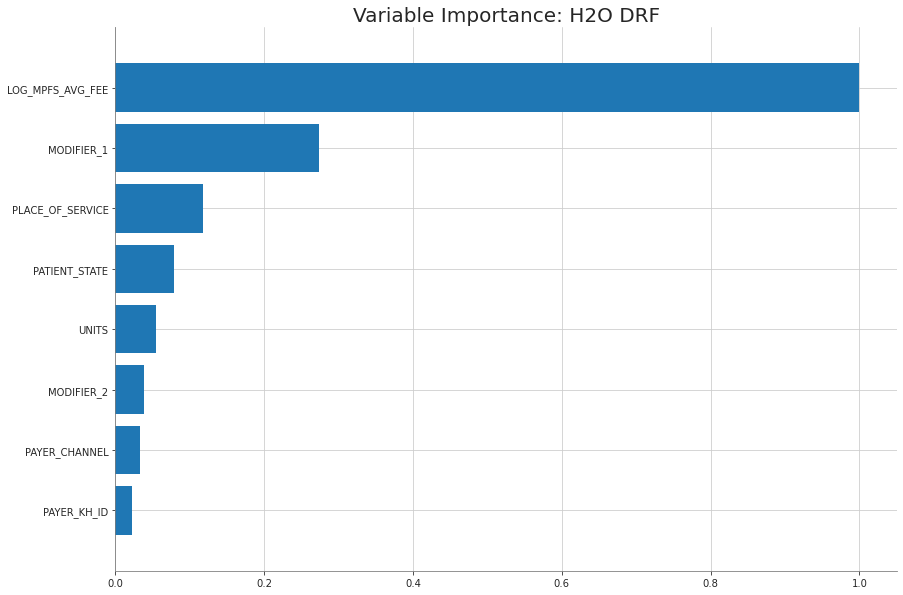

GLM_1_AutoML_20210702_183757


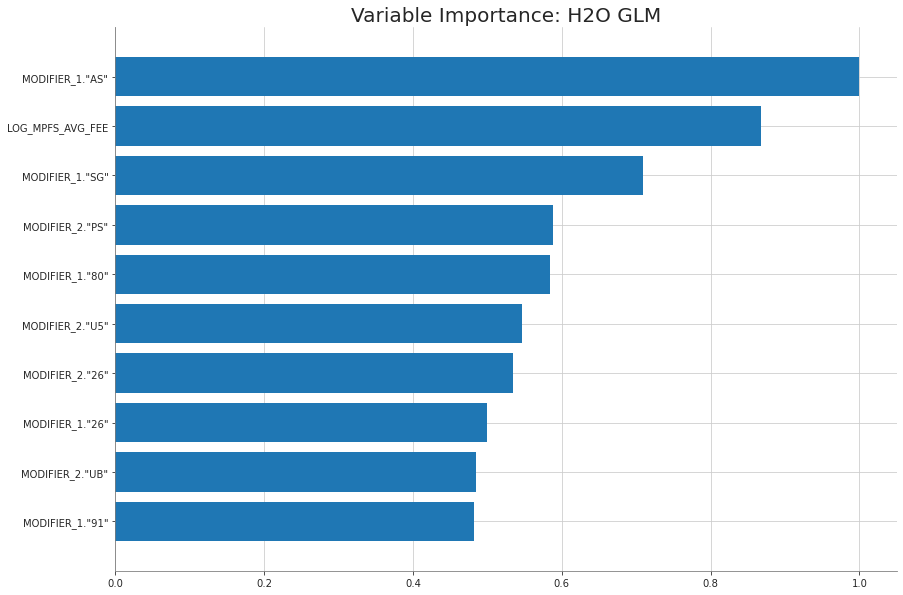

In [39]:
for model in model_ids[:5]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.varimp_plot()
    except:
        print ("plot attempt failed")

DRF_1_AutoML_20210702_183757
XRT_1_AutoML_20210702_183757
GLM_1_AutoML_20210702_183757


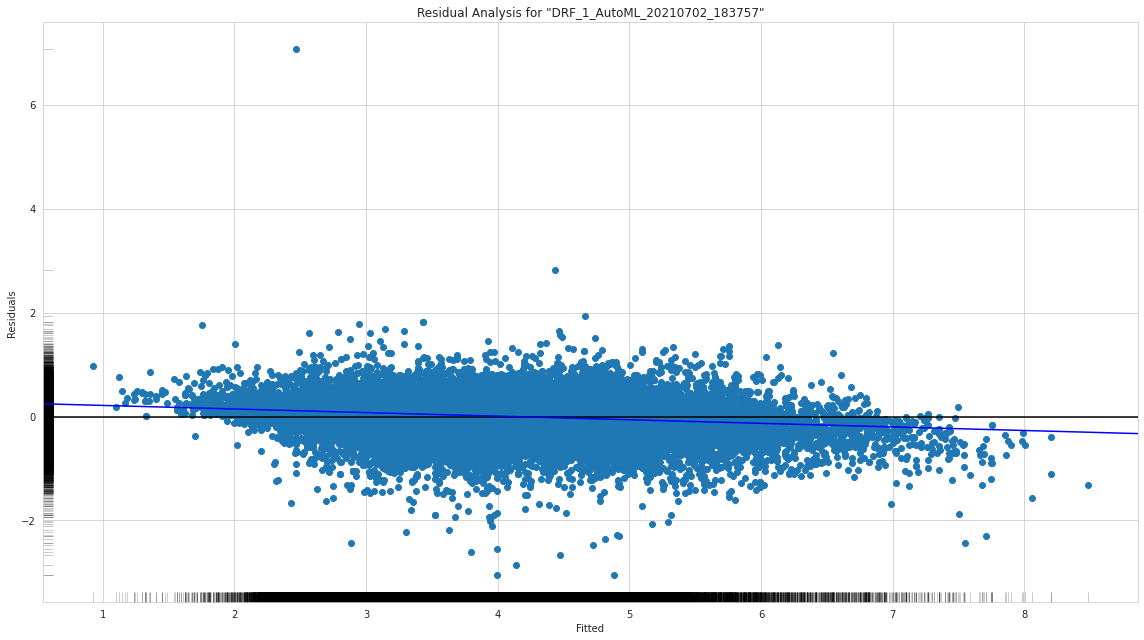

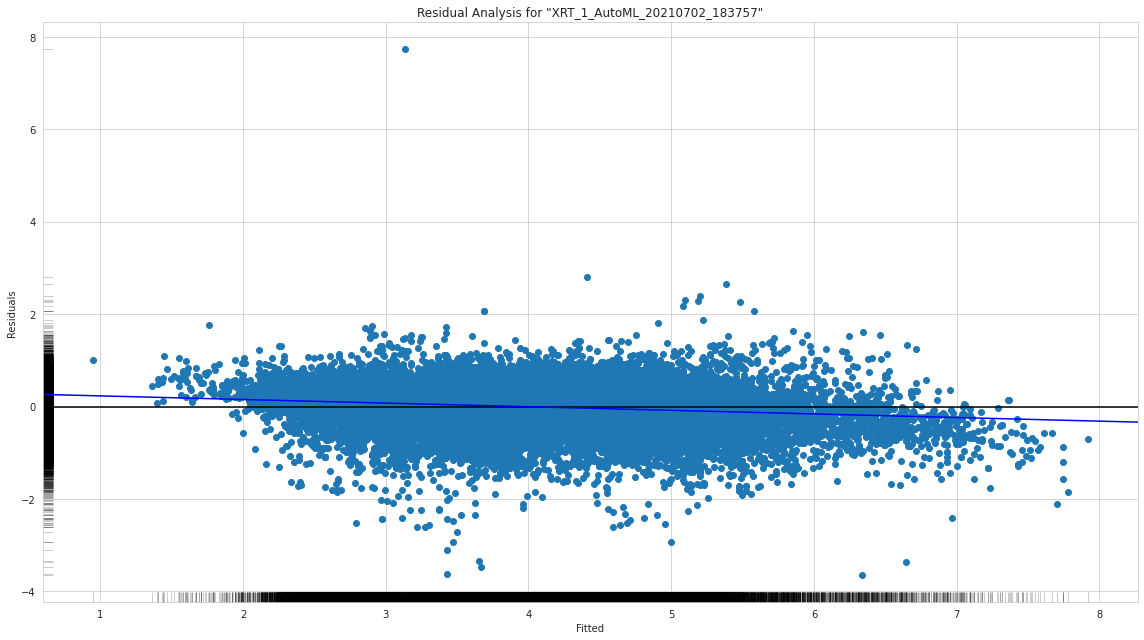

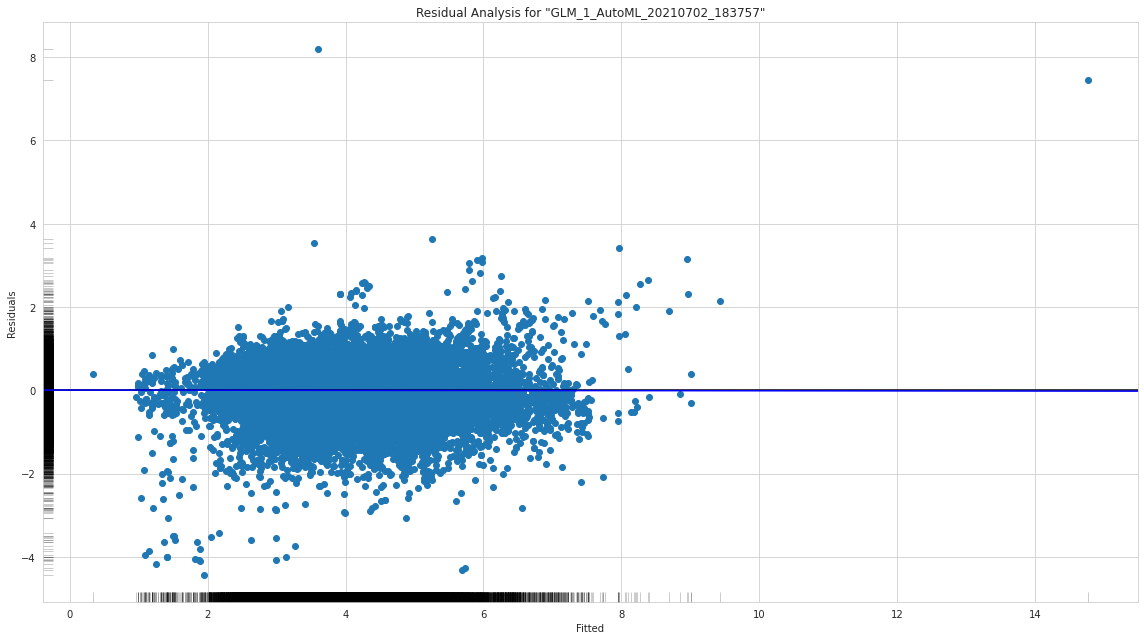

In [40]:
for model in model_ids[:5]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.residual_analysis_plot(trainH2o)
    except:
        print ("plot attempt failed")

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

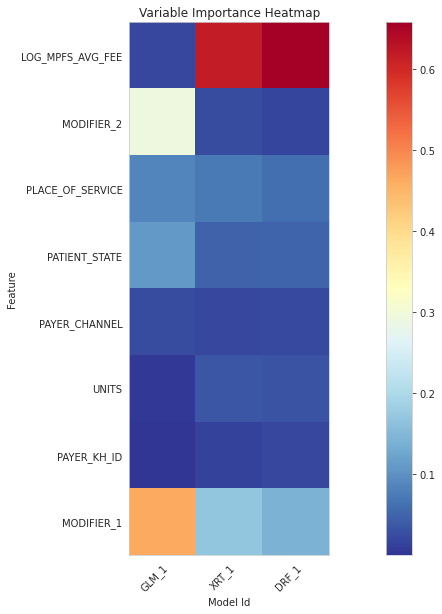

In [41]:
exa=aml2.explain(trainH2o, include_explanations=["varimp_heatmap"])

In [ ]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    yhat=temp.predict(testH2o).as_data_frame()
    temp_result=pd.concat([yhat["predict"].reset_index(), X_test.reset_index()], axis=1, ignore_index=True)
    temp_result.columns=["index1", "yhat", "index2"]+X_test.columns.to_list()
    temp_result["residual"]=yhat-temp_result["LOG_ALLOWED_AMOUNT"]
    mse1=sqrt(mse(yhat,temp_result["LOG_ALLOWED_AMOUNT"]))
    mse2=sqrt(mse(temp_result["LOG_MPFS_AVG_FEE"],temp_result["LOG_ALLOWED_AMOUNT"]))
    mse3=sqrt(mse(log(temp_result["PROC_AVERAGE_AA"]),temp_result["LOG_ALLOWED_AMOUNT"]))
    mse4=sqrt(mse(log(temp_result["ALL_AVERAGE_AA"]),temp_result["LOG_ALLOWED_AMOUNT"]))
    print(mse1,mse2, mse3, mse4)


In [ ]:
sns.distplot(log(temp_result["residual"]),
         kde_kws={"shade": True}, hist=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel

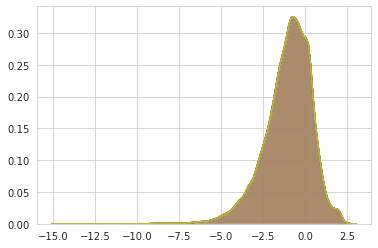

In [223]:
soc_list = temp_result['VISIT_SETTING_OF_CARE'].unique()  
pd_list = [temp_result.loc[temp_result['VISIT_SETTING_OF_CARE'] == soc] for soc in soc_list]

for pd_temp in pd_list:
    sns.distplot(log(temp_result[['residual']]), kde_kws={"shade": True},hist=False)

[Text(0, 0, 'Outpatient Visit'),
 Text(0, 0, 'Home Visit'),
 Text(0, 0, 'Laboratory Visit'),
 Text(0, 0, 'Inpatient Visit'),
 Text(0, 0, 'Emergency Room Visit'),
 Text(0, 0, 'Ambulance Visit'),
 Text(0, 0, 'Non-hospital institution Visit'),
 Text(0, 0, 'Pharmacy Visit')]

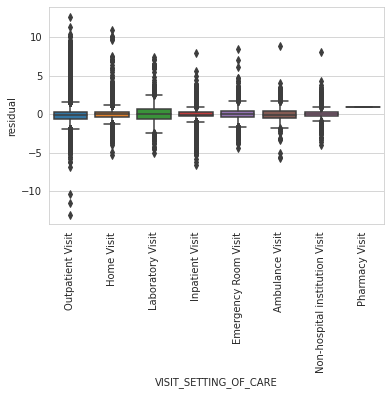

In [231]:
g=sns.boxplot(x="VISIT_SETTING_OF_CARE", y="residual", data=temp_result)

g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [224]:
pd_list[0].head()

,index1,yhat,index2,PROCEDURE,PATIENT_STATE,PAYER_KH_ID,PAYER_CHANNEL,CLAIM_TYPE_CODE,MODIFIER_1,MODIFIER_2,UNITS,PLACE_OF_SERVICE,VISIT_SETTING_OF_CARE,ALLOWED_AMOUNT,PROC_PRICE_MEAN,GLOBAL_PRICE_MEAN,LOG_ALLOWED_AMOUNT_CENTER,residual
0,0,0.875429,34713,"""28190""",NY,328,Managed Medicaid,P,"""LT""",None,1,"""11""",Outpatient Visit,182.00,301.675000,183.466628,0.911488,-0.205877
5,5,0.934715,43221,"""92551""",MA,244,Commercial,P,None,None,1,"""11""",Outpatient Visit,25.00,28.226290,183.466628,0.963662,-0.096691
6,6,0.820826,146449,"""92014""",TX,266,Commercial,P,None,None,1,"""11""",Outpatient Visit,59.00,123.792704,183.466628,0.846206,-0.122300
7,7,0.806377,73855,"""85025""",TX,73,Managed Medicaid,P,None,None,None,"""11""",Outpatient Visit,7.25,47.773766,183.466628,0.512353,1.136837
10,10,0.964611,27815,"""93460""",OH,186,Commercial,I,None,None,1,None,Outpatient Visit,10812.56,919.090769,183.466628,1.361269,-2.706552


In [225]:
pd_list[1].head()

,index1,yhat,index2,PROCEDURE,PATIENT_STATE,PAYER_KH_ID,PAYER_CHANNEL,CLAIM_TYPE_CODE,MODIFIER_1,MODIFIER_2,UNITS,PLACE_OF_SERVICE,VISIT_SETTING_OF_CARE,ALLOWED_AMOUNT,PROC_PRICE_MEAN,GLOBAL_PRICE_MEAN,LOG_ALLOWED_AMOUNT_CENTER,residual
1,1,0.889628,32366,"""S9131""",AR,186,Commercial,I,None,None,1,None,Home Visit,134.00,137.771818,183.466628,0.994364,-0.515887
4,4,1.005210,8478,"""T4527""",TX,251,Managed Medicaid,P,None,None,240,"""12""",Home Visit,117.60,75.606304,183.466628,1.102126,-0.419213
78,78,0.952818,185945,"""A7038""",CA,186,Commercial,P,"""NU""","""KX""",3,"""12""",Home Visit,12.39,10.097051,183.466628,1.088506,-0.313742
85,85,0.824861,183446,"""G0299""",LA,21,Commercial,I,None,None,1,None,Home Visit,115.00,175.525243,183.466628,0.918176,-0.482231
92,92,0.984680,159408,"""W1793""",PA,70,Managed Medicaid,P,None,None,48,"""12""",Home Visit,239.04,168.793057,183.466628,1.067846,-0.426529


In [221]:
temp_result.columns

Index(['index1', 'yhat', 'index2', 'PROCEDURE', 'PATIENT_STATE', 'PAYER_KH_ID',
       'PAYER_CHANNEL', 'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT',
       'PROC_PRICE_MEAN', 'GLOBAL_PRICE_MEAN', 'LOG_ALLOWED_AMOUNT_CENTER',
       'residual'],
      dtype='object')

In [216]:
for model_name in model_ids:
    model=h2o.get_model(model_name)
    model_path = h2o.save_model(model=model, path="dev/costofcare/analysis/h2o_models/", force=True)
    print (model_path)

/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/StackedEnsemble_AllModels_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/StackedEnsemble_BestOfFamily_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_3
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_2_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_1
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_2
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/GBM_4_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_1_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1

#### Run Basic Model w/SOC

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    X_model[yName],
                                                    test_size=0.5, random_state=0)

In [13]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=7200, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train[xNames_1] ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test[xNames_1]], axis=1))
aml.train(x=xNames_1, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
20:48:59.551: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [14]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210418_204859,0.111169,0.33342,0.111169,0.154233,nan
XGBoost_grid__1_AutoML_20210418_204859_model_87,0.111527,0.333956,0.111527,0.154193,nan
XGBoost_grid__1_AutoML_20210418_204859_model_16,0.112312,0.33513,0.112312,0.154704,nan
StackedEnsemble_AllModels_AutoML_20210418_204859,0.112486,0.33539,0.112486,0.154043,nan
GBM_5_AutoML_20210418_204859,0.113134,0.336353,0.113134,0.158345,nan
XGBoost_grid__1_AutoML_20210418_204859_model_71,0.113136,0.336357,0.113136,0.156835,nan
XGBoost_grid__1_AutoML_20210418_204859_model_56,0.113568,0.336998,0.113568,0.156636,nan
DRF_1_AutoML_20210418_204859,0.113759,0.337281,0.113759,0.157132,nan
GBM_grid__1_AutoML_20210418_204859_model_5,0.113876,0.337456,0.113876,0.157441,nan
XGBoost_grid__1_AutoML_20210418_204859_model_29,0.113889,0.337475,0.113889,0.157673,nan


In [15]:
model_ids=aml.leaderboard.as_data_frame()["model_id"].tolist()

In [16]:
model_ids

['StackedEnsemble_BestOfFamily_AutoML_20210418_204859',
 'XGBoost_grid__1_AutoML_20210418_204859_model_87',
 'XGBoost_grid__1_AutoML_20210418_204859_model_16',
 'StackedEnsemble_AllModels_AutoML_20210418_204859',
 'GBM_5_AutoML_20210418_204859',
 'XGBoost_grid__1_AutoML_20210418_204859_model_71',
 'XGBoost_grid__1_AutoML_20210418_204859_model_56',
 'DRF_1_AutoML_20210418_204859',
 'GBM_grid__1_AutoML_20210418_204859_model_5',
 'XGBoost_grid__1_AutoML_20210418_204859_model_29',
 'XGBoost_grid__1_AutoML_20210418_204859_model_38',
 'XGBoost_grid__1_AutoML_20210418_204859_model_107',
 'GBM_grid__1_AutoML_20210418_204859_model_35',
 'GBM_grid__1_AutoML_20210418_204859_model_37',
 'GBM_grid__1_AutoML_20210418_204859_model_17',
 'GBM_grid__1_AutoML_20210418_204859_model_29',
 'XGBoost_grid__1_AutoML_20210418_204859_model_40',
 'XGBoost_grid__1_AutoML_20210418_204859_model_51',
 'GBM_grid__1_AutoML_20210418_204859_model_4',
 'XGBoost_grid__1_AutoML_20210418_204859_model_9',
 'XGBoost_grid__1_A

StackedEnsemble_BestOfFamily_AutoML_20210418_204859
plot attempt failed
XGBoost_grid__1_AutoML_20210418_204859_model_87


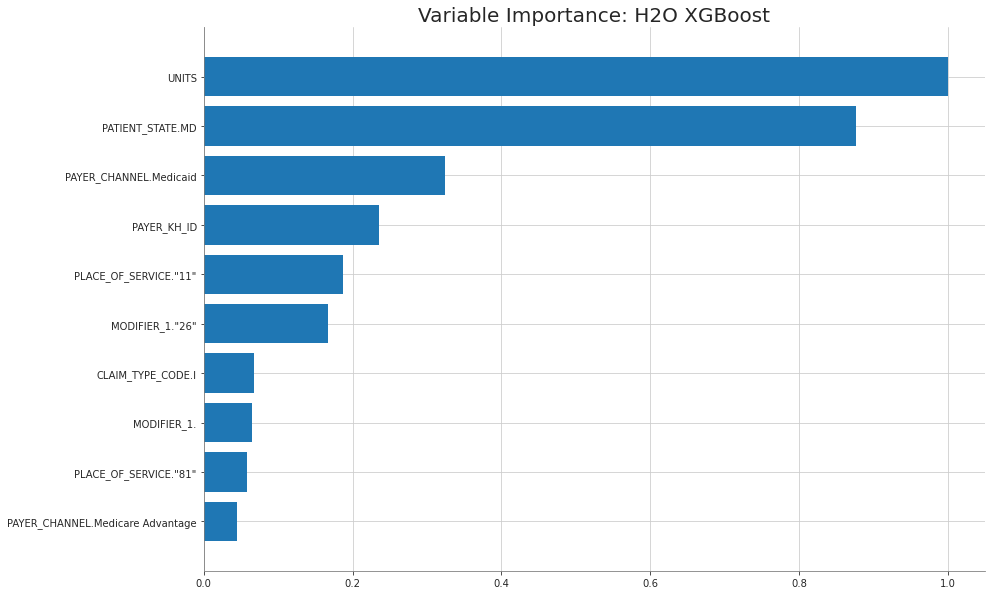

XGBoost_grid__1_AutoML_20210418_204859_model_16


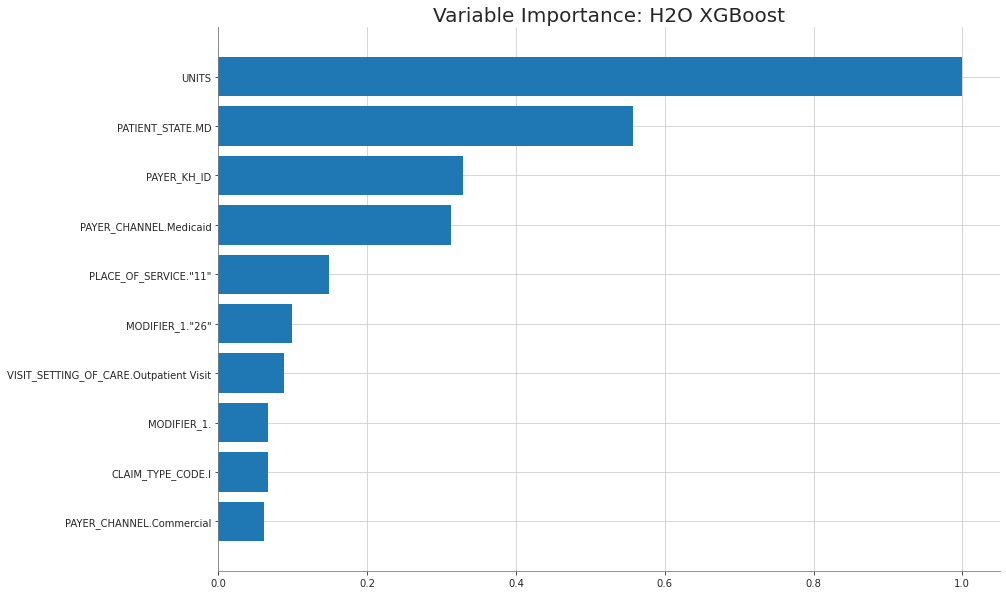

StackedEnsemble_AllModels_AutoML_20210418_204859
plot attempt failed
GBM_5_AutoML_20210418_204859


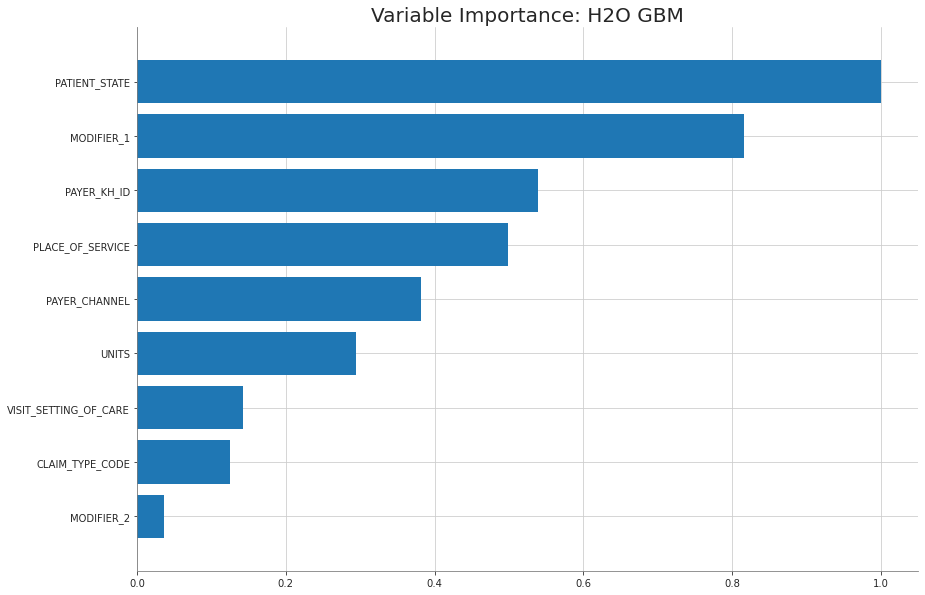

XGBoost_grid__1_AutoML_20210418_204859_model_71


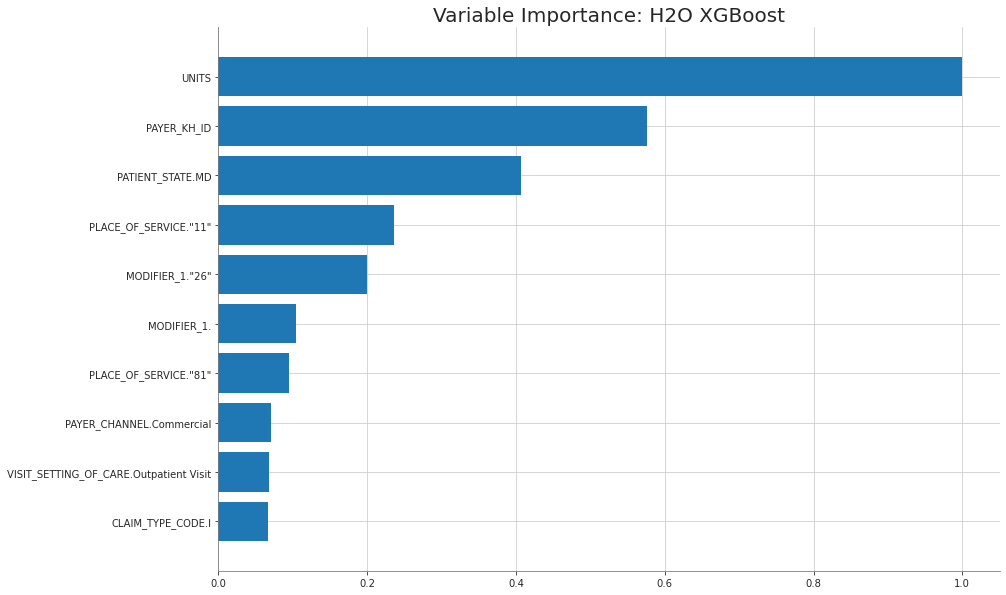

XGBoost_grid__1_AutoML_20210418_204859_model_56


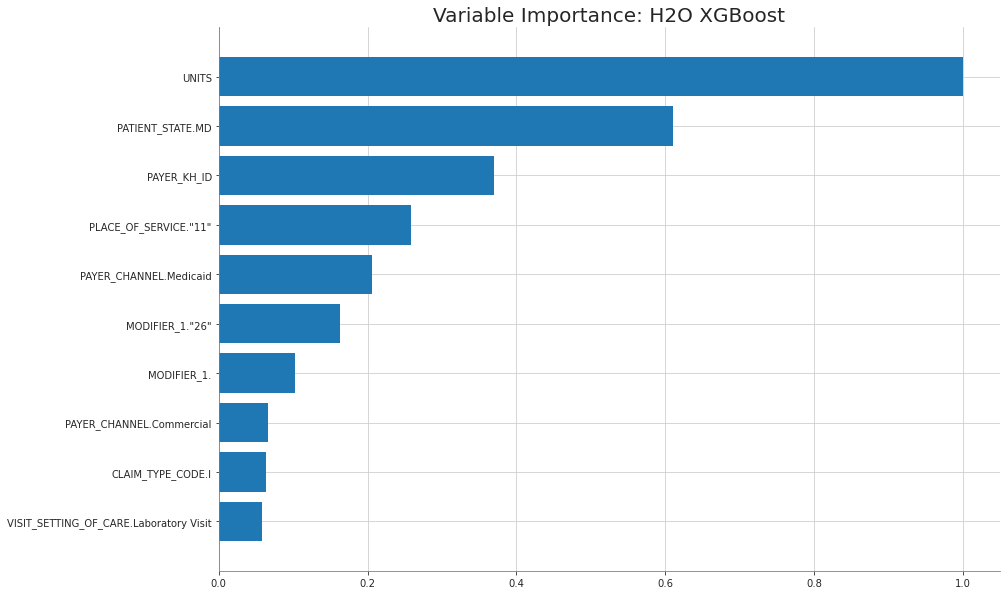

DRF_1_AutoML_20210418_204859


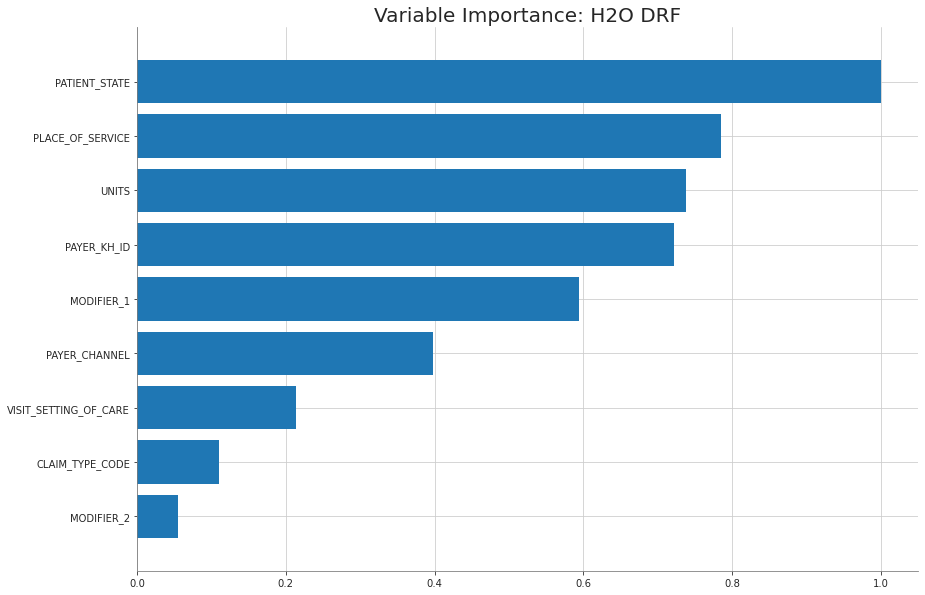

GBM_grid__1_AutoML_20210418_204859_model_5


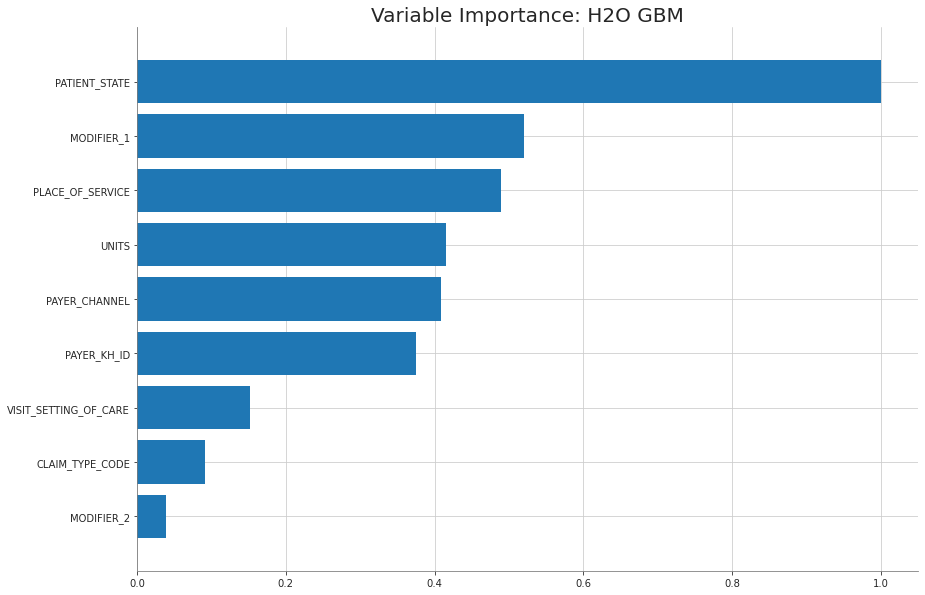

XGBoost_grid__1_AutoML_20210418_204859_model_29


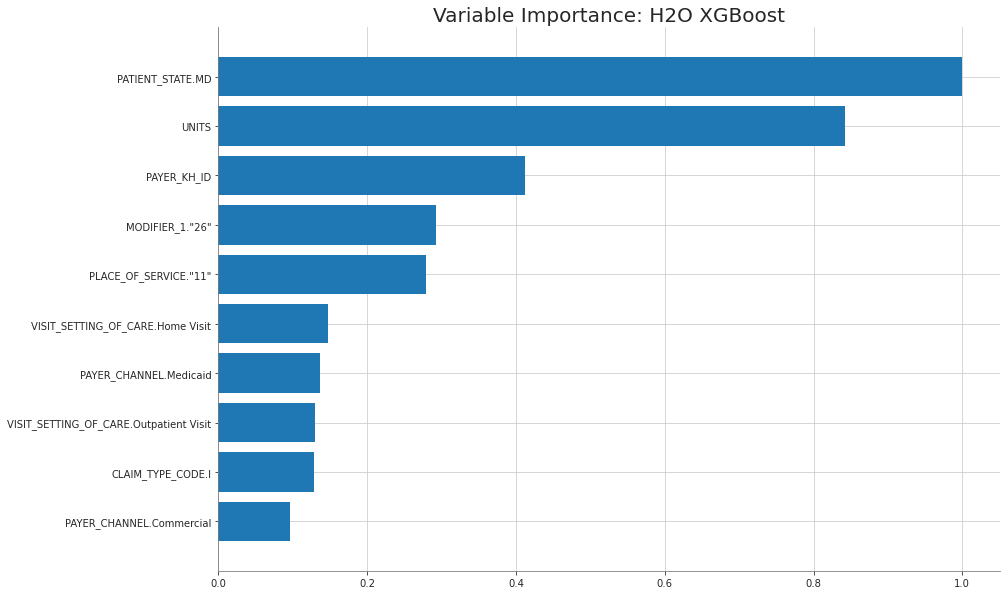

In [17]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.varimp_plot()
    except:
        print ("plot attempt failed")

StackedEnsemble_BestOfFamily_AutoML_20210418_204859
XGBoost_grid__1_AutoML_20210418_204859_model_87
XGBoost_grid__1_AutoML_20210418_204859_model_16
StackedEnsemble_AllModels_AutoML_20210418_204859
GBM_5_AutoML_20210418_204859
XGBoost_grid__1_AutoML_20210418_204859_model_71
XGBoost_grid__1_AutoML_20210418_204859_model_56
DRF_1_AutoML_20210418_204859
GBM_grid__1_AutoML_20210418_204859_model_5
XGBoost_grid__1_AutoML_20210418_204859_model_29


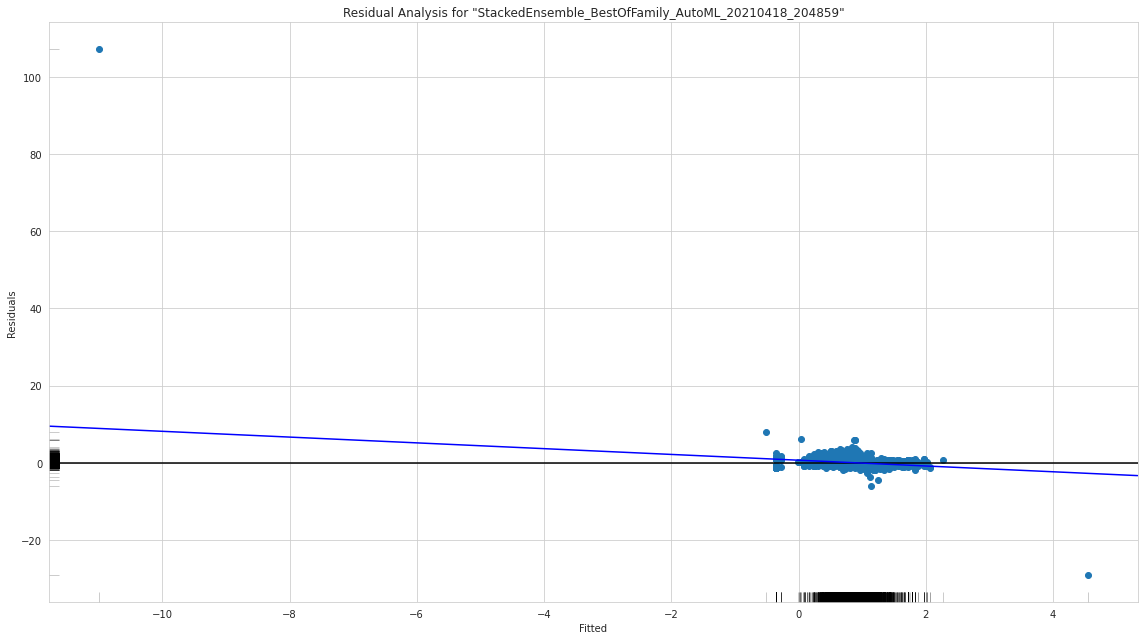

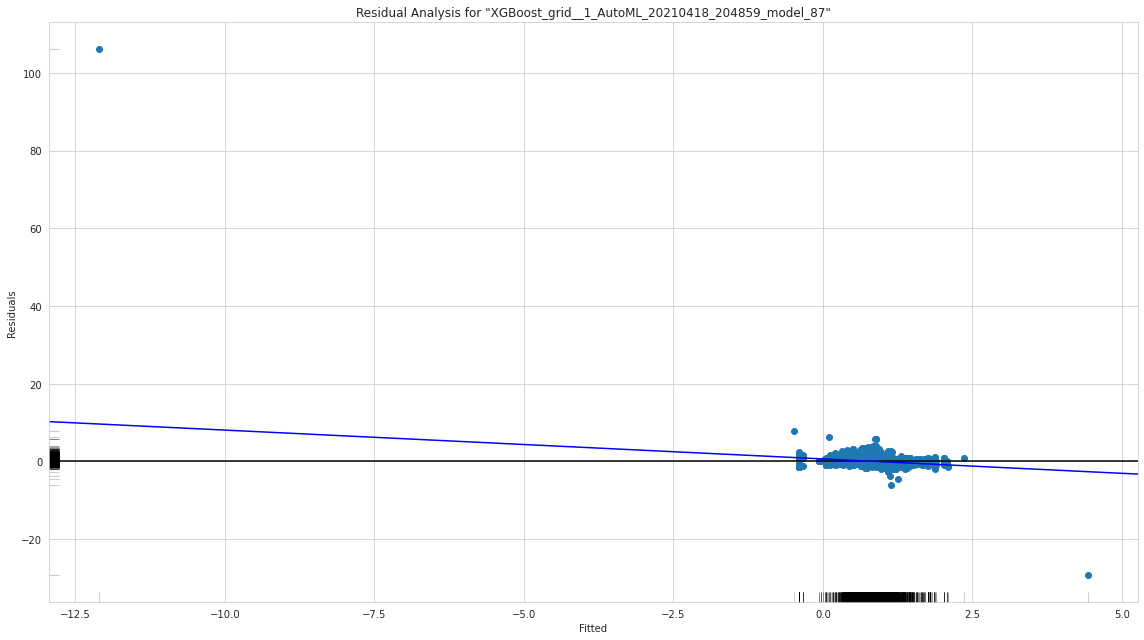

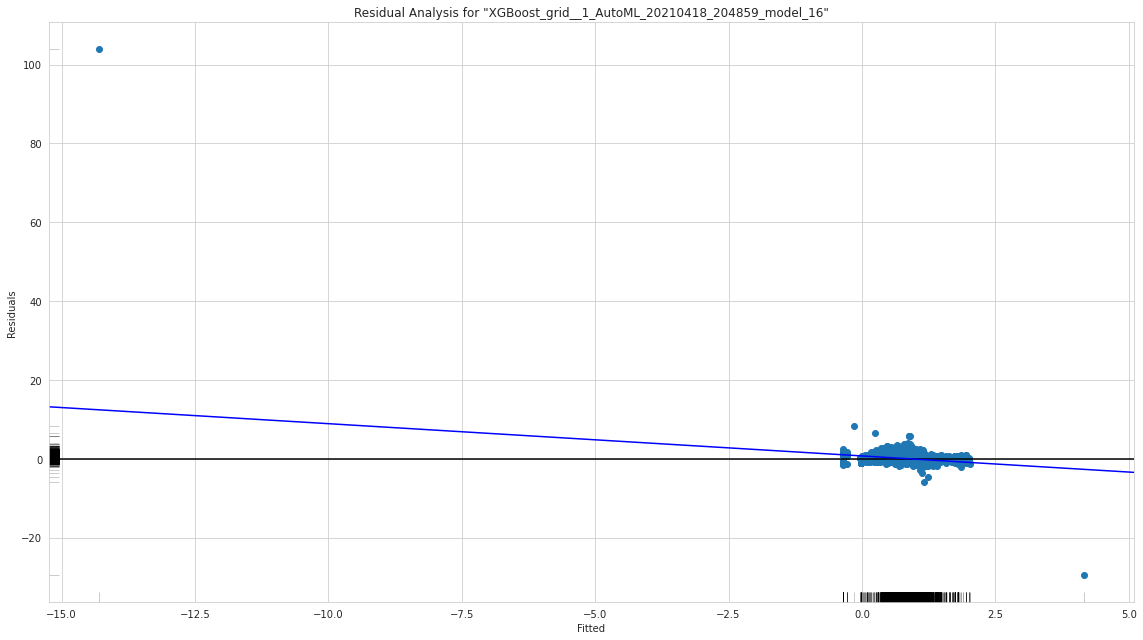

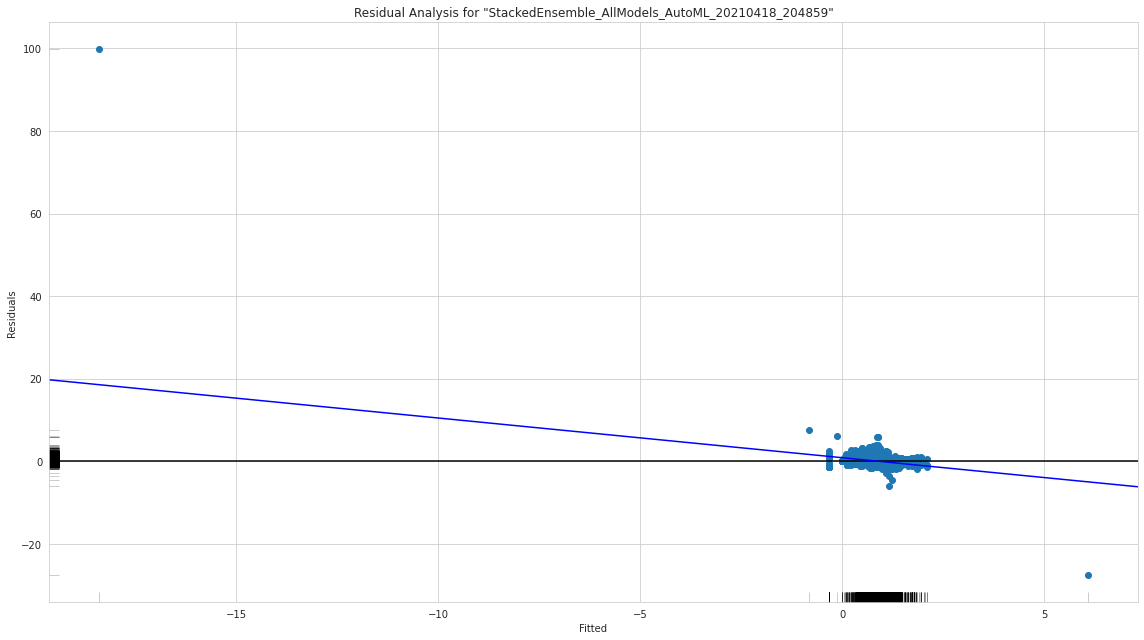

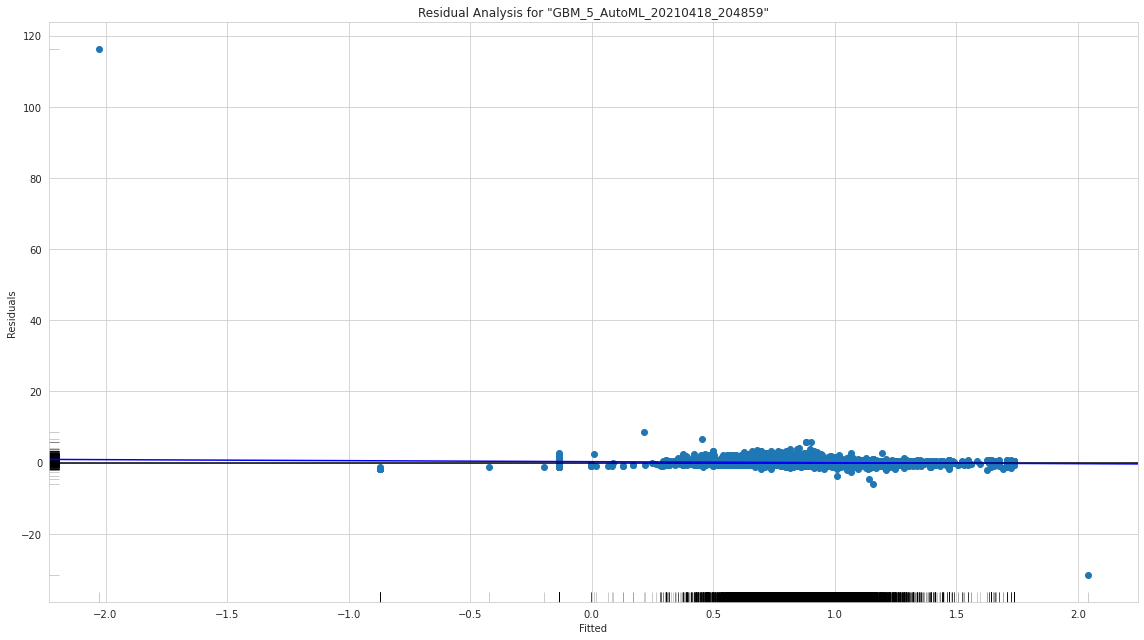

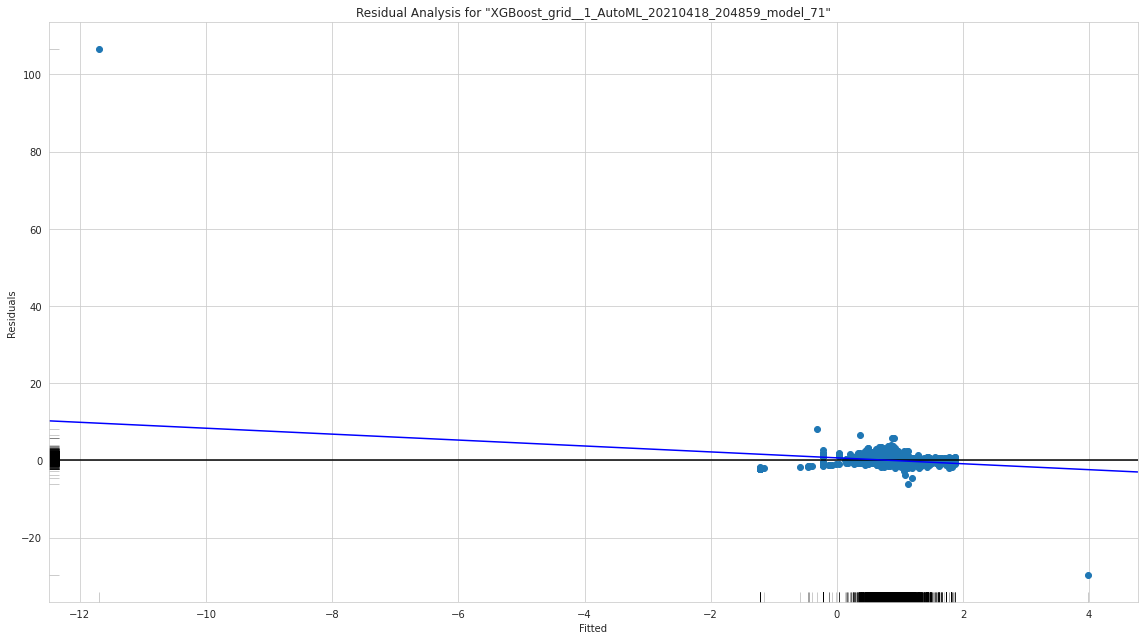

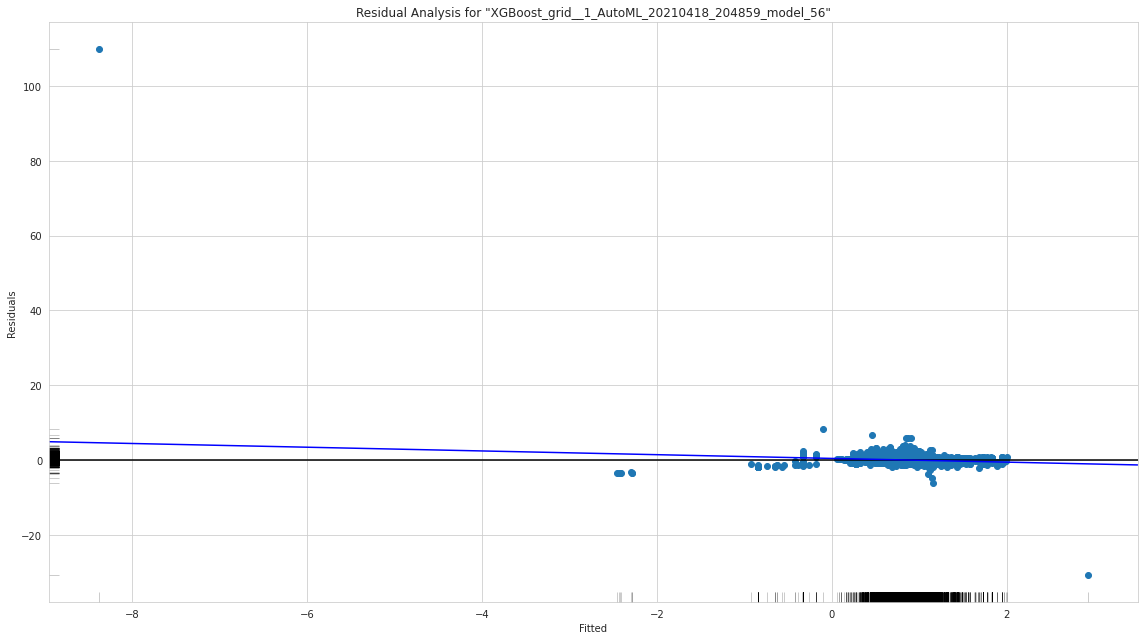

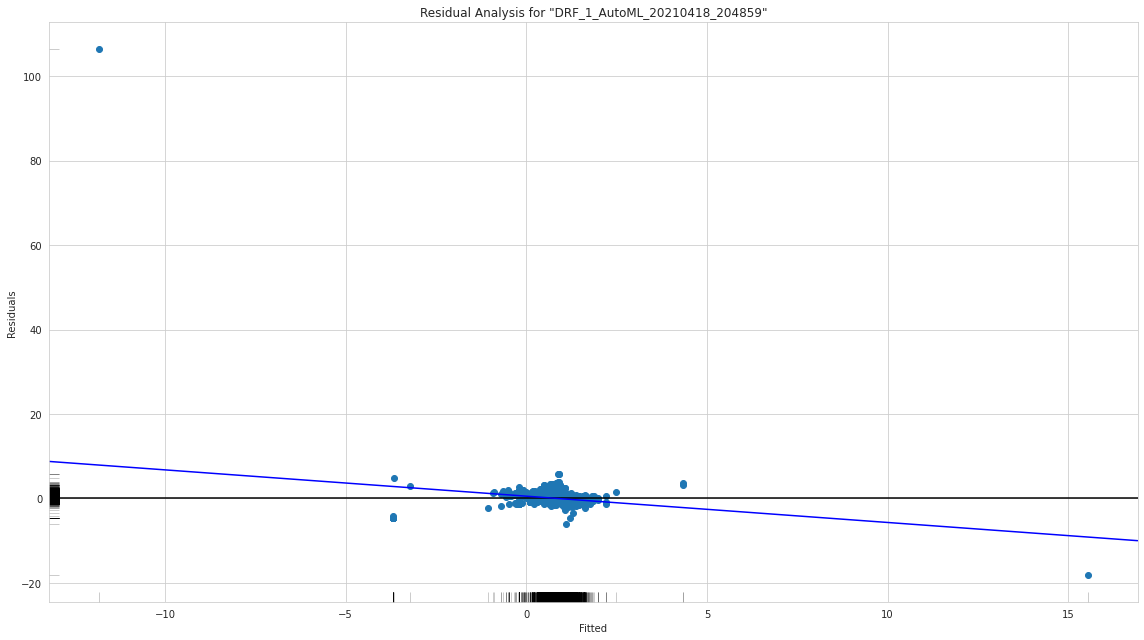

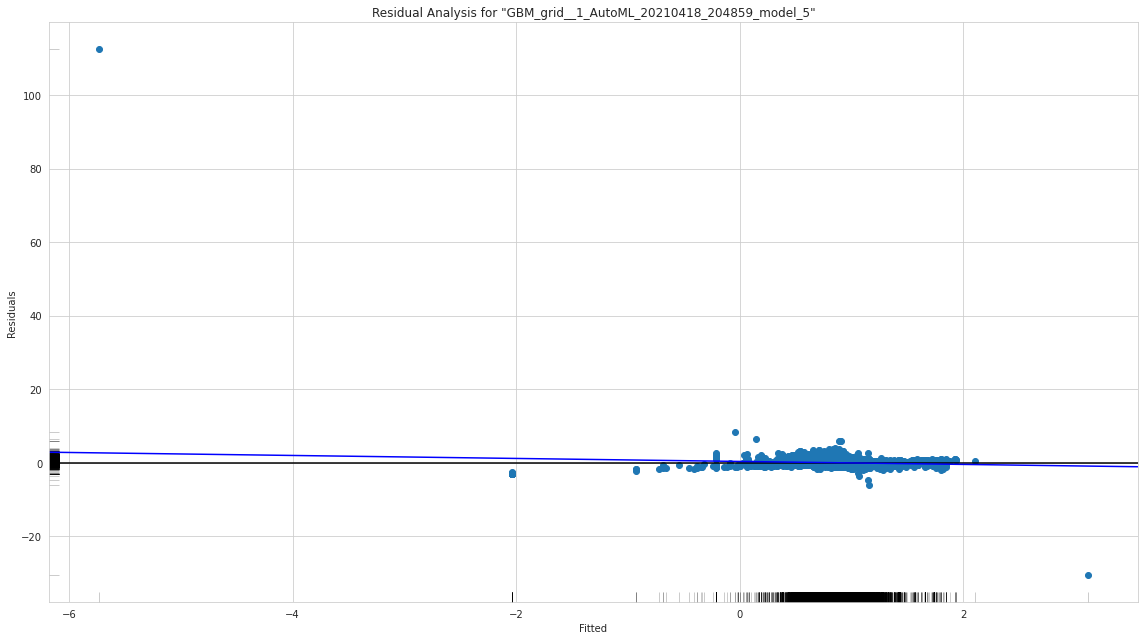

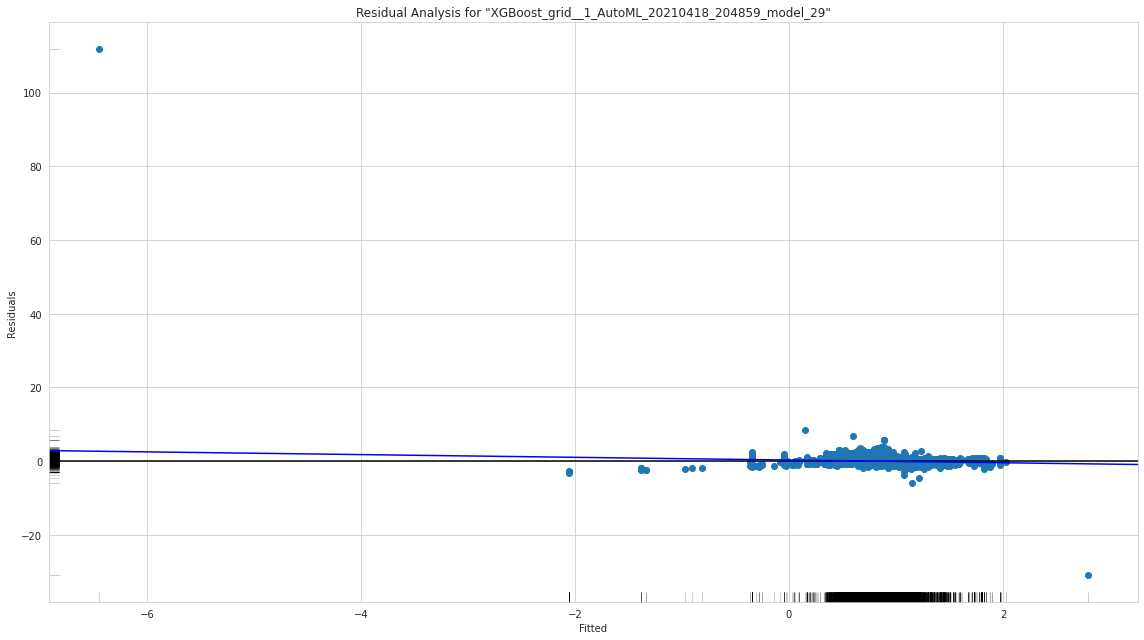

In [18]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.residual_analysis_plot(trainH2o)
    except:
        print ("plot attempt failed")

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

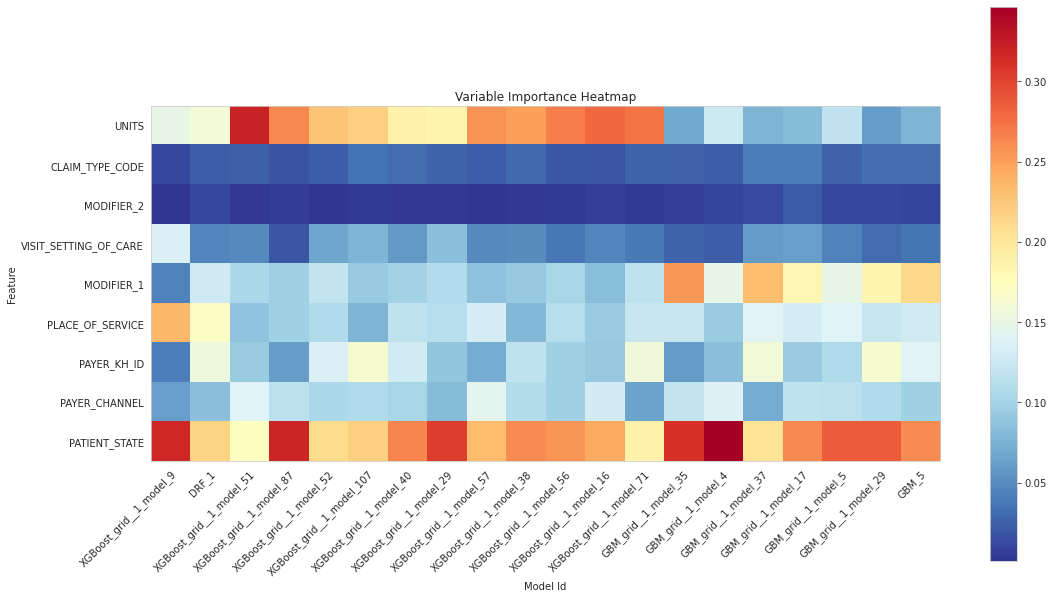

In [19]:
exa=aml.explain(trainH2o, include_explanations=["varimp_heatmap"])

In [20]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    yhat=temp.predict(testH2o).as_data_frame()
    temp_result=pd.concat([yhat["predict"].reset_index(), X_test.reset_index()], axis=1, ignore_index=True)
    temp_result.columns=["index1", "yhat", "index2"]+X_test.columns.to_list()
    #mod_yhat=temp_result["yhat"]*log(temp_result["PROC_PRICE_MEAN"])
    temp_result["residual"]=mod_yhat-log(temp_result["ALLOWED_AMOUNT"])
    mse1=sqrt(mse(yhat,temp_result["LOG_MPFS_AVG_FEE"]))
    mse2=sqrt(mse(yhat,temp_result["LOG_MPFS_AVG_FEE"]))
    mse3=sqrt(mse(yhat,temp_result["LOG_MPFS_AVG_FEE"]))
    mse4=sqrt(mse(yhat,temp_result["LOG_MPFS_AVG_FEE"]))
    print(mse1,mse2,mse3)


StackedEnsemble_BestOfFamily_AutoML_20210418_204859
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0057350041876618 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_87
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0095268940176954 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_16
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0153327276731174 1.2259589918412097 2.049179482039793
StackedEnsemble_AllModels_AutoML_20210418_204859
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0163254697157935 1.2259589918412097 2.049179482039793
GBM_5_AutoML_20210418_204859
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0208746824376662 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_71
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0214797055375981 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_56
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0286545350524865 1.2259589918412097 2.049179482039793
DRF_1_AutoML_20210418_204859
drf prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0389327475323553 1.2259589918412097 2.049179482039793
GBM_grid__1_AutoML_20210418_204859_model_5
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0328487280763654 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_29
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0322032392741047 1.2259589918412097 2.049179482039793


In [26]:
for model_name in model_ids:
    model=h2o.get_model(model_name)
    model_path = h2o.save_model(model=model, path="h2o_models/", force=True)
    print (model_path)

/home/jovyan/dev/costofcare/analysis/h2o_models/StackedEnsemble_BestOfFamily_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_87
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_16
/home/jovyan/dev/costofcare/analysis/h2o_models/StackedEnsemble_AllModels_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/GBM_5_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_71
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_56
/home/jovyan/dev/costofcare/analysis/h2o_models/DRF_1_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/GBM_grid__1_AutoML_20210418_204859_model_5
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_29
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_2021041

/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_79
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_54
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_72
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_7
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_62
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_81
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_120
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_55
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_4
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_121
/home/jovyan/dev/costofcare/analysis/h2o

## Price Model Blueprint

![PriceModel](PriceModel.jpg)

![CocModel](CoCModels.jpg)

## OLD CODE (DEPRECATED)

In [42]:
np.exp(.38)

1.4622845894342245

In [52]:
1/1.5

0.6666666666666666